#### Regression Analysis on Emergency Responding Time and ML Prediction

In this notebook, we do regression analysis on AED related interventions using statsmodels package and do machine learning prediction (train, parameter tuning, prediction) on the emergency responding time by gradient boosting model and kernel SVM using sklearn package. The main findings of this analysis are, by controling other variables, if the intervention is covered by medical facilities (`medical_coverage = 1`), the responding time (`waiting_time` in dataset) and the operation time (`total_time` in dataset) will decrease significantly (with p-value = 0.000). The prediction performance of ML models does not show much differences (Loss_GBR = 660.54, Loss_SVM = 662.55).  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
itv_aed = pd.read_csv(
    '/Users/lye/Downloads/MDA/Github-MDA2024/1_Data/CLEANED/intervention_aed_related_distance.csv',
    low_memory=False)

itv_aed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43093 entries, 0 to 43092
Data columns (total 56 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   mission_id                        43093 non-null  int64  
 1   service_name                      38978 non-null  object 
 2   postalcode_permanence             27284 non-null  float64
 3   cityname_permanence               28483 non-null  object 
 4   streetname_permanence             28631 non-null  object 
 5   housenumber_permanence            2156 non-null   float64
 6   latitude_permanence               39916 non-null  float64
 7   longitude_permanence              40255 non-null  float64
 8   permanence_short_name             43053 non-null  object 
 9   permanence_long_name              38982 non-null  object 
 10  vector_type                       42545 non-null  object 
 11  eventtype_firstcall               27434 non-null  object 
 12  even

In [3]:
## Datetime validation

itv_aed['t0'] = pd.to_datetime(itv_aed['t0'])
itv_aed['t3'] = pd.to_datetime(itv_aed['t3'])
itv_aed['t5'] = pd.to_datetime(itv_aed['t5'])
itv_aed['t7'] = pd.to_datetime(itv_aed['t7'])
itv_aed['t3-t0'] = (itv_aed['t3'] - itv_aed['t0']).dt.total_seconds() / 60
itv_aed['t5-t0'] = (itv_aed['t5'] - itv_aed['t0']).dt.total_seconds() / 60
itv_aed['total_time'] = (itv_aed['t7'] - itv_aed['t0']).dt.total_seconds() / 60

itv_aed.loc[(itv_aed['t3-t0'] <= 0) | (itv_aed['t3-t0'] > 6 * 60),
            't3-t0'] = np.nan
itv_aed.loc[(itv_aed['t5-t0'] <= 0) | (itv_aed['t5-t0'] > 12 * 60) |
            (itv_aed['t5-t0'] <= itv_aed['t3-t0']), 't5-t0'] = np.nan
itv_aed.loc[(itv_aed['waiting_time'] <= 0) |
            (itv_aed['waiting_time'] > 6 * 60), 'waiting_time'] = np.nan
itv_aed['t3-t0'] = itv_aed.apply(
    lambda x: x['waiting_time']
    if pd.isna(x['t3-t0']) and pd.notna(x['waiting_time']) else x['t3-t0'],
    axis=1)

itv_aed.loc[(itv_aed['total_time'] <= 0) |
            (itv_aed['total_time'] <= itv_aed['t5-t0']), 'total_time'] = np.nan
itv_aed.drop(columns=['waiting_time'], inplace=True)
itv_aed.rename(columns={
    't3-t0': 'waiting_time',
    't5-t0': 'time_to_hospital'
},
               inplace=True)  ## rename to waiting_time & time_to_hospital

itv_aed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43093 entries, 0 to 43092
Data columns (total 58 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   mission_id                        43093 non-null  int64         
 1   service_name                      38978 non-null  object        
 2   postalcode_permanence             27284 non-null  float64       
 3   cityname_permanence               28483 non-null  object        
 4   streetname_permanence             28631 non-null  object        
 5   housenumber_permanence            2156 non-null   float64       
 6   latitude_permanence               39916 non-null  float64       
 7   longitude_permanence              40255 non-null  float64       
 8   permanence_short_name             43053 non-null  object        
 9   permanence_long_name              38982 non-null  object        
 10  vector_type                       42545 non-nu

In [4]:
## drop duplicates and missing values
itv_aed.drop_duplicates(subset=['mission_id'], inplace=True)
itv_aed.dropna(subset=[
    'waiting_time', 'total_time', 'time_to_hospital', 'aed_distance', 'hospital_distance',
    'province', 'vector_type', 'eventlevel_trip'
], inplace=True)

## validate vector_type to "MUG", "AMBULANCE", "PIT"
itv_aed['vector_type'] = itv_aed['vector_type'].apply(lambda x: "AMBULANCE" if any(
    i in x.lower() for i in ["ambulance", "amb"]) else 'MUG' if any(
    i in x.lower() for i in ['mug']) else 'PIT' if any(
    i in x.lower() for i in ['pit']) else x)

itv_aed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9732 entries, 3 to 28626
Data columns (total 58 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   mission_id                        9732 non-null   int64         
 1   service_name                      9732 non-null   object        
 2   postalcode_permanence             9467 non-null   float64       
 3   cityname_permanence               9719 non-null   object        
 4   streetname_permanence             9732 non-null   object        
 5   housenumber_permanence            691 non-null    float64       
 6   latitude_permanence               9722 non-null   float64       
 7   longitude_permanence              9685 non-null   float64       
 8   permanence_short_name             9732 non-null   object        
 9   permanence_long_name              9732 non-null   object        
 10  vector_type                       9732 non-null   ob

In [5]:
## Delete 'provincie' in province column
itv_aed['province'] = itv_aed['province'].apply(lambda x: x.replace('Provincie ', ''))
itv_aed['province'].value_counts()

province
Antwerpen                         2588
Henegouwen                        1670
Brussels Hoofdstedelijk Gewest    1384
Luik                              1253
Limburg                           1160
Namen                              713
Waals-Brabant                      480
Luxemburg                          428
Vlaams-Brabant                      52
West-Vlaanderen                      3
Oost-Vlaanderen                      1
Name: count, dtype: int64

In [6]:
## Generate variable "medical coverage" binary variable: 1 if the intervention is covered by aed/hospital else 0

itv_aed['medical_coverage'] = itv_aed.apply(lambda x: 1 if x['aed_distance'] <= 200 or x['hospital_distance'] <= 2000 else 0, axis=1)
itv_aed['medical_coverage'].value_counts()

medical_coverage
0    5195
1    4537
Name: count, dtype: int64

In [7]:
itv_aed.to_csv('/Users/lye/Downloads/MDA/Github-MDA2024/1_Data/CLEANED/clean_itv_aed_for_reg_analysis.csv', index=False)

In [15]:
columns_to_keep = [
    'aed_distance', 'hospital_distance', 'medical_coverage', 'waiting_time', 'time_to_hospital',
    'total_time', 'province', 'vector_type', 'eventlevel_trip', 'eventtype_trip', 'abandon_reason'
]

itv_reg = itv_aed[columns_to_keep].copy()
itv_reg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9732 entries, 3 to 28626
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   aed_distance       9732 non-null   float64
 1   hospital_distance  9732 non-null   float64
 2   medical_coverage   9732 non-null   int64  
 3   waiting_time       9732 non-null   float64
 4   time_to_hospital   9732 non-null   float64
 5   total_time         9732 non-null   float64
 6   province           9732 non-null   object 
 7   vector_type        9732 non-null   object 
 8   eventlevel_trip    9732 non-null   object 
 9   eventtype_trip     9732 non-null   object 
 10  abandon_reason     25 non-null     object 
dtypes: float64(5), int64(1), object(5)
memory usage: 912.4+ KB


In [16]:
itv_reg = pd.get_dummies(itv_reg, columns=['province', 'vector_type', 'eventlevel_trip', 'eventtype_trip'], drop_first=True)
itv_reg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9732 entries, 3 to 28626
Data columns (total 27 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   aed_distance                                                      9732 non-null   float64
 1   hospital_distance                                                 9732 non-null   float64
 2   medical_coverage                                                  9732 non-null   int64  
 3   waiting_time                                                      9732 non-null   float64
 4   time_to_hospital                                                  9732 non-null   float64
 5   total_time                                                        9732 non-null   float64
 6   abandon_reason                                                    25 non-null     object 
 7   province_Brussels Hoofdstedelijk Gewe

In [17]:
itv_reg.columns

Index(['aed_distance', 'hospital_distance', 'medical_coverage', 'waiting_time',
       'time_to_hospital', 'total_time', 'abandon_reason',
       'province_Brussels Hoofdstedelijk Gewest', 'province_Henegouwen',
       'province_Limburg', 'province_Luik', 'province_Luxemburg',
       'province_Namen', 'province_Oost-Vlaanderen', 'province_Vlaams-Brabant',
       'province_Waals-Brabant', 'province_West-Vlaanderen', 'vector_type_MUG',
       'vector_type_PIT', 'eventlevel_trip_N1', 'eventlevel_trip_N2',
       'eventlevel_trip_N3', 'eventlevel_trip_N4', 'eventlevel_trip_N5',
       'eventlevel_trip_N6', 'eventlevel_trip_N7A',
       'eventtype_trip_P039 - Cardiac problem (other than thoracic pain)'],
      dtype='object')

In [23]:
## OLS regression on total_time
import statsmodels.api as sm

X_var = [
    'medical_coverage',
    'province_Brussels Hoofdstedelijk Gewest', 'province_Henegouwen',
    'province_Limburg', 'province_Luik', 'province_Luxemburg',
    'province_Namen', 'province_Oost-Vlaanderen', 'province_Vlaams-Brabant',
    'province_Waals-Brabant', 'province_West-Vlaanderen', 'vector_type_MUG',
    'vector_type_PIT', 'eventlevel_trip_N1', 'eventlevel_trip_N2',
    'eventlevel_trip_N3', 'eventlevel_trip_N4', 'eventlevel_trip_N5',
    'eventlevel_trip_N6', 'eventlevel_trip_N7A',
    'eventtype_trip_P039 - Cardiac problem (other than thoracic pain)'
]

y_var = 'total_time'

X = itv_reg[X_var]
y = itv_reg[y_var]
X = sm.add_constant(X)

model = sm.OLS(y, X.astype(float)).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             total_time   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     51.16
Date:                Thu, 23 May 2024   Prob (F-statistic):          1.56e-202
Time:                        18:39:42   Log-Likelihood:                -46176.
No. Observations:                9732   AIC:                         9.240e+04
Df Residuals:                    9710   BIC:                         9.255e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
====================================================================================================================================
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
const                                                               90.7619      2.505     36.236      0.000      85.852      95.672
medical_coverage                                                   -10.9781      0.593    -18.503      0.000     -12.141      -9.815
province_Brussels Hoofdstedelijk Gewest                             -0.9977      1.001     -0.997      0.319      -2.960       0.965
province_Henegouwen                                                 -1.0188      0.898     -1.134      0.257      -2.780       0.742
province_Limburg                                                     2.9135      1.009      2.886      0.004       0.935       4.892
province_Luik                                                       -2.5128      0.969     -2.594      0.009      -4.411      -0.614
province_Luxemburg                                                  14.4855      1.467      9.877      0.000      11.611      17.360
province_Namen                                                       9.1384      1.193      7.662      0.000       6.800      11.476
province_Oost-Vlaanderen                                            -6.4912     27.863     -0.233      0.816     -61.109      48.126
province_Vlaams-Brabant                                             -1.3563      3.920     -0.346      0.729      -9.040       6.327
province_Waals-Brabant                                               5.0713      1.400      3.623      0.000       2.328       7.815
province_West-Vlaanderen                                            -4.7562     16.101     -0.295      0.768     -36.319      26.806
vector_type_MUG                                                     -3.6881      1.073     -3.439      0.001      -5.790      -1.586
vector_type_PIT                                                      2.5539      1.067      2.394      0.017       0.463       4.645
eventlevel_trip_N1                                                   4.3743      2.854      1.533      0.125      -1.220       9.968
eventlevel_trip_N2                                                   2.5105      3.026      0.830      0.407      -3.420       8.441
eventlevel_trip_N3                                                   0.5584      3.079      0.181      0.856      -5.477       6.594
eventlevel_trip_N4                                                  -4.7289      3.020     -1.566      0.117     -10.648       1.190
eventlevel_trip_N5                                                  -8.0092      2.957     -2.709      0.007     -13.805      -2.213
eventlevel_trip_N6                                                  -8.2864      6.376     -1.300      0.194     -20.784       4.211
eventlevel_trip_N7A     

In [24]:
## OLS regression on waiting_time
X = itv_reg[X_var]
y = itv_reg['waiting_time']
X = sm.add_constant(X)

model = sm.OLS(y, X.astype(float)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           waiting_time   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     20.82
Date:                Thu, 23 May 2024   Prob (F-statistic):           1.38e-77
Time:                        18:41:01   Log-Likelihood:                -35575.
No. Observations:                9732   AIC:                         7.119e+04
Df Residuals:                    9710   BIC:                         7.135e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
====================================================================================================================================
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
const                                                               12.2850      0.843     14.579      0.000      10.633      13.937
medical_coverage                                                    -2.0759      0.200    -10.400      0.000      -2.467      -1.685
province_Brussels Hoofdstedelijk Gewest                              1.5873      0.337      4.712      0.000       0.927       2.248
province_Henegouwen                                                  1.0640      0.302      3.521      0.000       0.472       1.656
province_Limburg                                                    -0.6329      0.340     -1.863      0.062      -1.299       0.033
province_Luik                                                       -0.0491      0.326     -0.151      0.880      -0.688       0.590
province_Luxemburg                                                   1.7597      0.493      3.566      0.000       0.792       2.727
province_Namen                                                       0.3381      0.401      0.843      0.400      -0.449       1.125
province_Oost-Vlaanderen                                            -2.0522      9.374     -0.219      0.827     -20.427      16.323
province_Vlaams-Brabant                                              8.5189      1.319      6.460      0.000       5.934      11.104
province_Waals-Brabant                                               1.2553      0.471      2.666      0.008       0.332       2.178
province_West-Vlaanderen                                             4.3410      5.417      0.801      0.423      -6.277      14.959
vector_type_MUG                                                      4.3671      0.361     12.103      0.000       3.660       5.074
vector_type_PIT                                                      1.7998      0.359      5.014      0.000       1.096       2.503
eventlevel_trip_N1                                                   0.7878      0.960      0.821      0.412      -1.094       2.670
eventlevel_trip_N2                                                   0.6703      1.018      0.658      0.510      -1.325       2.666
eventlevel_trip_N3                                                   0.5336      1.036      0.515      0.606      -1.497       2.564
eventlevel_trip_N4                                                   0.2771      1.016      0.273      0.785      -1.714       2.269
eventlevel_trip_N5                                                   0.2372      0.995      0.238      0.812      -1.713       2.187
eventlevel_trip_N6                                                   0.5543      2.145      0.258      0.796      -3.650       4.759
eventlevel_trip_N7A     

In [137]:
## GradientBoost prediction on total_time

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, LeaveOneOut

## prepare output and input variables
itv_model = itv_aed[columns_to_keep].copy()
y = itv_model['total_time']
X = itv_model.drop(columns=['total_time', 'waiting_time', 'time_to_hospital', 'abandon_reason'], inplace=False)

## one-hot encoding and standard scaling for input variables
ct = ColumnTransformer([
    ('one_hot', OneHotEncoder(drop='first', handle_unknown='ignore'),
     ['province', 'vector_type', 'eventlevel_trip', 'eventtype_trip']),
    ('standardize', StandardScaler(), ['aed_distance', 'hospital_distance'])
])

## AdaBoost pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) ## 80% train, 20% test

gbr_pipe = Pipeline([
    ('transform', ct),
    # ('reduce_dim', PCA(n_components=5, svd_solver="arpack")), ## 'arpack' for sparse input matrix
    ('gbr', GradientBoostingRegressor(n_estimators=100,
                                      learning_rate=0.01,
                                      subsample=1,
                                      loss='squared_error',
                                      max_depth=3,
                                      random_state=42))
])

gbr = gbr_pipe.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

print('The MSE of GradientBoosting is:', mse(y_test, y_pred))

The MSE of GradientBoosting is: 704.4242399385074


In [142]:
## Tuning hyperparameters with GridSearchCV

import warnings
with warnings.catch_warnings(): ## suppress user warnings: "The least populated class in y has only 1 members, which is less than n_splits=5.",
    ## which can cause the user warning in grid search phase
    warnings.simplefilter("ignore")

    param_grid_gbr = {
        # 'reduce_dim__n_components': [i+1 for i in range(3, 13)],  ## PCA components if using PCA to reduce dimension
        'gbr__n_estimators': [50, 100, 200, 500],
        'gbr__learning_rate': [0.01, 0.1, 1],
        'gbr__subsample': [0.5, 0.75, 1.0],
        'gbr__max_depth': range(3, 12, 2),
        'gbr__loss': ['squared_error', 'huber']
    }

    loocv = LeaveOneOut() ## Use leave-one-out cross-validation for grid search to avoid sparse data splitting issue
    gridsearch = GridSearchCV(gbr_pipe,
                              param_grid_gbr,
                              scoring='neg_mean_squared_error',
                              cv=5, # loocv, ## Use leave-one-out cross-validation for grid search may take pretty long time
                              # n_jobs=-1, ## Use all processors for parallel computing if possible
                              verbose=0).fit(X_train, y_train)
    print('The best parameters are:', gridsearch.best_params_, 'with negative MSE:', gridsearch.best_score_)

    ## test the model with best parameters in test set
    loss = gridsearch.score(X_test, y_test)
    print('The negative MSE of GradientBoost(test set) with best parameters is:', loss)

The best parameters are: {'gbr__learning_rate': 0.01, 'gbr__loss': 'huber', 'gbr__max_depth': 5, 'gbr__n_estimators': 500, 'gbr__subsample': 0.5} with negative MSE: -689.2002442000321
The negative MSE of GradientBoost(test set) with best parameters is: -660.5445438083801


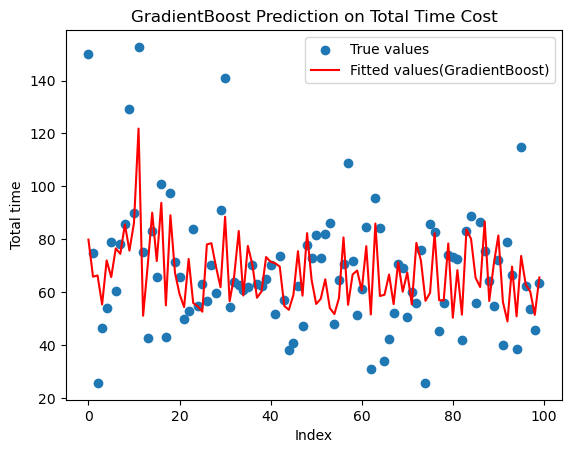

In [185]:
## visualize the regression results on test set

def visualize_results(X_test, y_test, model_name: str, gridsearch, num_samples=100):
    plt.figure()
    preds = gridsearch.predict(X_test)
    random_indices = np.random.choice(range(len(y_test)), num_samples, replace=False)
    plt.scatter(np.arange(num_samples), y_test.values[random_indices], label='True values')
    plt.plot(np.arange(num_samples), preds[random_indices], color='red', label=f'Fitted values({model_name})')
    plt.xlabel('Index')
    plt.ylabel('Total time')
    plt.title(f'{model_name} Prediction on Total Time Cost')
    plt.legend()
    plt.show()


## GradientBoost regression prediction vs. true value in test set
np.random.seed(1)
visualize_results(X_test, y_test, 'GradientBoost', gridsearch, num_samples=100)


In [186]:
## SVM prediction on total_time

svm_pipe = Pipeline([
    ('transform', ct),
    # ('reduce_dim', PCA(n_components=5, svd_solver="arpack")), ## 'arpack' for sparse input matrix
    ('svm', SVR(kernel='rbf', C=1, epsilon=0.1)) ## rbf kernel, C: penalty parameter(the higher the less regularization) , epsilon: margin of tolerance
])

svm_reg = svm_pipe.fit(X_train, y_train)
y_pred = svm_pipe.predict(X_test)

print('The MSE of SVM regression is:', mse(y_test, y_pred))

The MSE of SVM regression is: 682.9373221395955


In [187]:
## Tuning hyperparameters for SVM regression with GridSearchCV

import warnings
with warnings.catch_warnings():  ## suppress user warnings: "The least populated class in y has only 1 members, which is less than n_splits=5.",
                                ## which can cause the user warning in grid search phase
    warnings.simplefilter("ignore")

    param_grid_svm = {
        # 'reduce_dim__n_components': [i+1 for i in range(3, 13)],  ## PCA components
        'svm__kernel': ['poly', 'rbf', 'sigmoid'],
        'svm__C': [0.01, 0.1, 1, 10, 100],
        'svm__epsilon': [0.01, 0.1, 1, 10, 100],
        'svm__gamma': ['scale', 'auto']
    }

    gridsearch = GridSearchCV(
        svm_pipe,
        param_grid_svm,
        scoring='neg_mean_squared_error',
        cv=5,  # loocv, ## Use leave-one-out cross-validation for grid search may take pretty long time
        # n_jobs=-1, ## Use all processors for parallel computing if possible
        verbose=0).fit(X_train, y_train)
    print('The best parameters are:', gridsearch.best_params_,
          'with negative MSE:', gridsearch.best_score_)

    ## test the model with best parameters in test set
    loss = gridsearch.score(X_test, y_test)
    print('The negative MSE of SVM(test set) with best parameters is:', loss)

The best parameters are: {'svm__C': 100, 'svm__epsilon': 10, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'} with negative MSE: -692.5874492896049
The negative MSE of SVM(test set) with best parameters is: -662.5481847524599


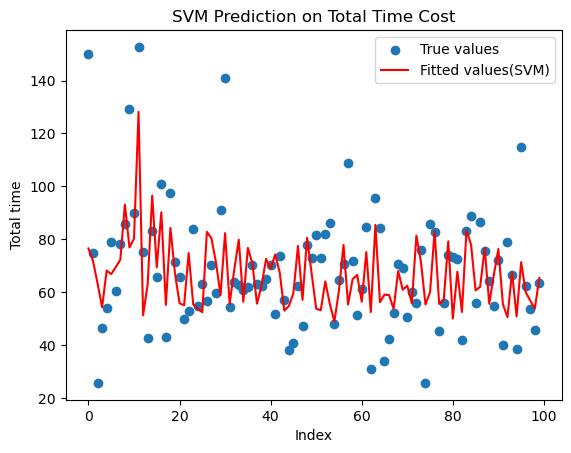

In [188]:
## SVM regression prediction vs. true value in test set
np.random.seed(1)
visualize_results(X_test, y_test, 'SVM', gridsearch, num_samples=100)